# Genre prediction from song lyrics

## The dataset

The data used for this project is made up of two different data sets, set #1: "artists-data.csv" and set #2: "lyrics-data.csv".

Set #1 is a data set that contains information about artists and their respective genres, how many songs they have produced and some information about popularity etc. It will be used with the artists name, the genre and the "link"-column, which will enable us to make a direct reference between the two data sets.

Set #2 contains information about specific songs, like song name, song lyrics, language and also the "link" column for the reference to the artists data set.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

### Artists data set:

First, we look at the artists data set.

We want to use the artists data set to find the respective artists genre for each song in the lyrics data set. We remove the unnecessary columns for preprocessing. The 'Link' column will be used to connect the song in the lyrics data set to the artists genres.

In [2]:
artists = pd.read_csv('artists-data.csv')
artists = artists.drop(['Popularity', 'Songs'], axis=1)
artists.head()

,Artist,Genres,Link
0,Ivete Sangalo,Pop; Axé; Romântico,/ivete-sangalo/
1,Chiclete com Banana,Axé,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,/banda-eva/
3,É O Tchan,Axé,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,/claudia-leitte/


### Lyrics data set:

We remove all songs that are not english, and then remove unnecessary columns.

In [3]:
lyrics = pd.read_csv('lyrics-data.csv')
lyrics = lyrics[lyrics['language'] == 'en'] # only want songs with english lyrics, 51% of the data set.
lyrics = lyrics.drop(['SLink', 'language'], axis=1) # remove unnecessary columns
lyrics = lyrics.reset_index() # reset the index
lyrics = lyrics.drop(['index'], axis=1)

In [4]:
lyrics.head()

,ALink,SName,Lyric
0,/ivete-sangalo/,Careless Whisper,I feel so unsure\nAs I take your hand and lead...
1,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school..."
2,/ivete-sangalo/,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c..."
3,/ivete-sangalo/,Easy,"Know it sounds funny\nBut, I just can't stand ..."
4,/ivete-sangalo/,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...


We know want to create the new and "final" data set from the lyrics data set by combining every entry with its corresponding genre by extracting it from the artists data set.

We can then pick out the 20 most frequent genres and look only at those, partly to decrease the amount of data, but also since we are not interested in being too specific with the classification, and we can expect genres such as "pop", "rock", "rap" etc. to be the most frequent anyway.

In [5]:
#merging 'Genre' from 'artists' into 'lyrics'
data = lyrics.merge(artists[['Link', 'Genres']], left_on='ALink', right_on='Link', how='left')

#dropping the 'Link' column from 'artists' as it's no longer needed
data.drop(['Link', 'ALink'], axis=1, inplace=True)

data['Genres'].value_counts()[0:20]

Genres
Country                         4774
Rock                            4672
Heavy Metal                     4394
Indie                           4289
Rap; Hip Hop                    3426
Pop                             2544
Hip Hop; Rap; Black Music       2456
Rock; Hard Rock; Heavy Metal    2130
Rap                             2012
Heavy Metal; Rock; Hard Rock    1781
Hip Hop; Rap                    1657
Heavy Metal; Hard Rock; Rock    1507
Indie; Rock                     1502
Soul Music; R&B                 1485
Gospel/Religioso                1431
Pop/Rock                        1374
Jazz                            1356
Punk Rock                       1310
Rap; Hip Hop; Black Music       1293
Reggae                          1255
Name: count, dtype: int64

In [6]:
#extract the data for the 20 most frequent genres
data = data[data['Genres'].isin(data['Genres'].value_counts()[0:21].index)]
data.shape
##about 48.000 entries

(47760, 3)

Since some artists have more than one genre, it would be interesting to treat that as a separate entry, to get a better understanding of how the genres are distributed. We do some processing of the genres and compare it to the data where artists have several genres:

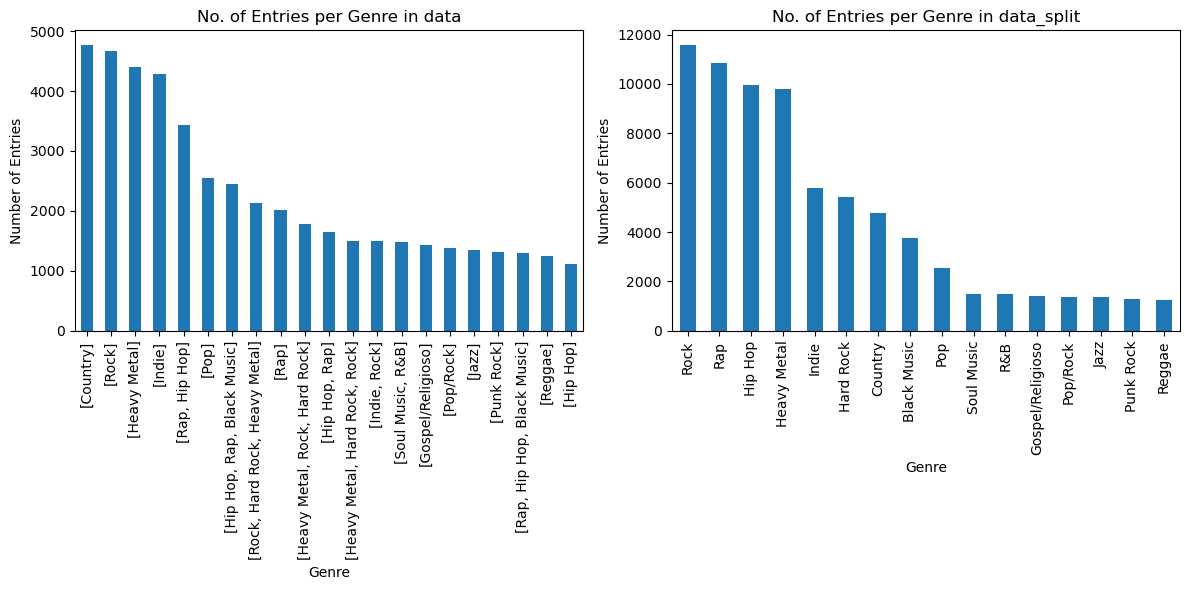

In [7]:
#turn genres into lists and remove whitespace in front of and after each genre
data['Genres'] = data['Genres'].apply(lambda x: [item.strip() for item in x.split(';')])
#create one row for each genre an artist have been labelled as
data_split = data.explode('Genres')
#plot the top 20 genres to see 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

#plot for 'artists' DataFrame
data['Genres'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('No. of Entries per Genre in data')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Number of Entries')

#plot for 'artists_split' DataFrame
data_split['Genres'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('No. of Entries per Genre in data_split')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Number of Entries')

plt.tight_layout()
plt.show()

Splitting the different genres and representing them as separate entries looks better, but we still have "Pop/Rock". We can fix that aswell. The genres list contains all the "normal" genres that any other of the genres could fit into. If any genre in the data contains that word, for example "Hard rock" contains "rock", then that should be assigned to "Rock".

In [22]:
genres = ['rock', 'rap', 'hip hop', 'metal', 'indie', 'country', 'black music', 'pop', 'soul', 'R&B', 'gospel', 'jazz', 'reggae']

def find_genre(entry):
    for genre in genres:
        if genre in entry.lower():
            return genre
    return entry  # If no genre is found, return the original entry

data_split['Genres'] = data_split['Genres'].apply(find_genre)


<Axes: xlabel='Genres'>

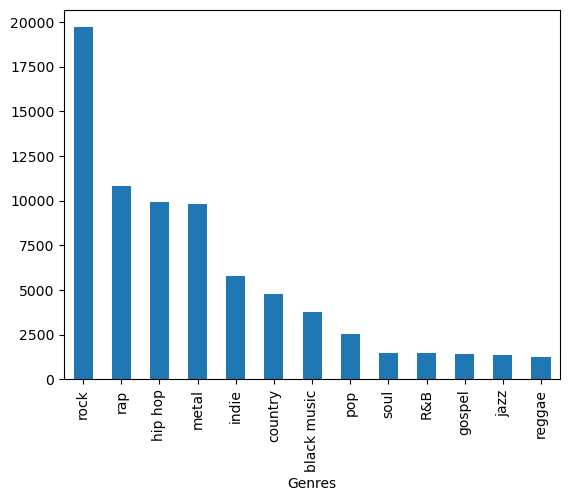

In [23]:
data_split['Genres'].value_counts().plot(kind='bar')

In [20]:
genre_counts = data_split['Genres'].value_counts()
genre_percentages = (genre_counts / len(data_split)) * 100

print(genre_percentages)

Genres
rock           26.554663
rap            14.621649
hip hop        13.408123
metal          13.230139
indie           7.808371
country         6.437085
black music     5.055013
pop             3.430236
soul            2.002319
R&B             2.002319
gospel          1.929508
jazz            1.828380
reggae          1.692196
Name: count, dtype: float64


This looks better, but now we can see that the data is pretty unbalanced, as ~ 26,5% of the songs are now labelled as "rock".

If we continue with this data set, we will not be able to use accuracy as a good evaluation of the model, since the unbalanced data will not give a fair view of the models performance, since for example it could statistically have 26,5% accuracy from only guessing "rock" every time.

We could ignore this and still go on to train our model, our we could do some over- or undersampling to balance the data.

#### TODO DATA MANIPULATION:

<ul>
    <li>Over- or undersampling</li>
    <li>Split into train/test/valid</li>
</ul>
